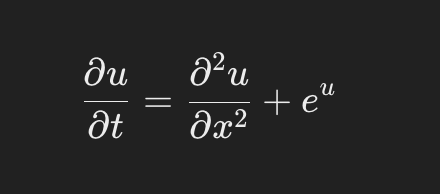

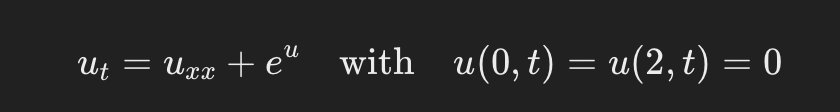

This equation describes how the function
u(x,t) , u(x,t) evolves over space and time with nonlinear growth due to the exponential term.

The differential equation  is a partial differential equation (PDE) that describes how the function

u(x,t), which depends on both space (
and time , evolves over time due to two components:

The spatial diffusion term, represented by the second spatial derivative
∂
2
u
∂
x
2
∂x
2

∂
2
 u
​
 , which governs how the quantity
u
u spreads out spatially.
The nonlinear exponential growth term,
e
u
e
u
 , which causes the function
u
u to grow nonlinearly over time.
The PDE is:

∂
u
∂
t
=
∂
2
u
∂
x
2
+
e
u
∂t
∂u
​
 =
∂x
2

∂
2
 u
​
 +e
u

with boundary conditions:

u(0,t)=u(2,t)=0
This means that at both spatial boundaries

x=0 and

x=2, the function

u is always 0 for any time
t
t.

Data Generation for the PINN Model
To generate data for training the Physics-Informed Neural Network (PINN), i likely followed these steps:

Numerical Solution: You can solve this PDE using numerical methods, such as finite differences or finite elements, in MATLAB. The solution involves discretizing both space (x) and time (t), solving the equation iteratively to find

u(x,t) at each time step.
Export to CSV: After solving the PDE in MATLAB, you can export the results (values of x,t, and the corresponding

u(x,t)) to a CSV file. This file is then used as training data to compare the predicted solution from the PINN model against the exact numerical solution.
In the PINN model, you enforce both the PDE and the boundary conditions as part of the loss function, while the data loss is calculated using the exact solution from the CSV file to supervise the learning.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the PINN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)  # Output layer (u(x,t))
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.hidden_layer(inputs)

# Instantiate the network
net = Net().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

# PDE Loss function (physics-based loss)
def physics_loss(pt_x, pt_t, net):
    u_pred = net(pt_x, pt_t)

    # Compute the first-order and second-order derivatives using autograd
    u_x = torch.autograd.grad(u_pred, pt_x, torch.ones_like(u_pred), create_graph=True)[0]
    u_t = torch.autograd.grad(u_pred, pt_t, torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, pt_x, torch.ones_like(u_x), create_graph=True)[0]

    # Define the PDE constraint: u_t = u_xx + exp(u)
    pde_residual = u_t - u_xx - torch.exp(u_pred)

    # PDE loss is the mean square of the residuals
    pde_loss = torch.mean(pde_residual**2)

    return pde_loss

# Boundary loss function for enforcing boundary conditions
def boundary_loss(net):
    # Boundary conditions at x = 0 and x = 2, across all times t
    t_bc = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)  # All time points

    # Enforce u(0, t) = u(2, t) = 0 (or some specified boundary condition)
    x_bc_0 = torch.zeros_like(t_bc).to(device)  # x = 0
    x_bc_2 = torch.ones_like(t_bc) * 2.0  # x = 2

    u_bc_0_pred = net(x_bc_0, t_bc)
    u_bc_2_pred = net(x_bc_2, t_bc)

    # Boundary loss is the MSE of the boundary conditions
    bc_loss = torch.mean((u_bc_0_pred - 0.0)**2) + torch.mean((u_bc_2_pred - 0.0)**2)  # Assuming u = 0 at boundaries

    return bc_loss

# Data loss function for supervised learning
def data_loss(pt_x, pt_t, pt_u, net):
    u_pred = net(pt_x, pt_t)
    return criterion(u_pred, pt_u)

# Training loop with combined loss (physics + data + boundary)
epochs = 10000

# Load data points from MATLAB-generated solution (u_data.csv)
data = pd.read_csv("/content/u_data.csv")
data = data.rename(columns={'0': 'X', '0.1': 'U', '0.2': 'T'})

# Convert to torch tensors
data_x = torch.tensor(data['X'].values).float().reshape(-1, 1).to(device)
data_t = torch.tensor(data['T'].values).float().reshape(-1, 1).to(device)
data_u = torch.tensor(data['U'].values).float().reshape(-1, 1).to(device)

for epoch in range(epochs):
    optimizer.zero_grad()

    # Define input data (x, t) for physics loss
    pt_x = torch.rand(100, 1, requires_grad=True).to(device)
    pt_t = torch.rand(100, 1, requires_grad=True).to(device)

    # Compute the combined loss: physics loss + data loss + boundary loss
    total_loss = physics_loss(pt_x, pt_t, net) + data_loss(data_x, data_t, data_u, net) + boundary_loss(net)

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss.item()}")

# Save the trained model
torch.save(net.state_dict(), "pinn_model_uxt_with_boundary.pt")

# Plotting the results after training
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate grid for predictions
x = np.linspace(0, 2, 100)
t = np.linspace(0, 1, 100)
ms_x, ms_t = np.meshgrid(x, t)

# Prepare input for the network
x_flat = ms_x.ravel().reshape(-1, 1)
t_flat = ms_t.ravel().reshape(-1, 1)

pt_x = Variable(torch.from_numpy(x_flat).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t_flat).float(), requires_grad=True).to(device)

# Get predictions from the trained model
pt_u = net(pt_x, pt_t)
u = pt_u.data.cpu().numpy()

# Reshape the predictions for plotting
ms_u = u.reshape(ms_x.shape)

# Plot the surface
surf = ax.plot_surface(ms_x, ms_t, ms_u, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


Epoch 0/10000, Loss: 0.41809460520744324
Epoch 1000/10000, Loss: 0.0023718627635389566
Epoch 2000/10000, Loss: 0.001972015481442213
Epoch 3000/10000, Loss: 0.0019303429871797562
Epoch 4000/10000, Loss: 0.0019411395769566298
Epoch 5000/10000, Loss: 0.0017658710712566972
Epoch 6000/10000, Loss: 0.0017259987071156502
Epoch 7000/10000, Loss: 0.001889631967060268
Epoch 8000/10000, Loss: 0.0017174473032355309
Epoch 9000/10000, Loss: 0.001723947934806347


<ipython-input-9-407e8a3311bf>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("pinn_model_uxt_with_boundary.pt"))


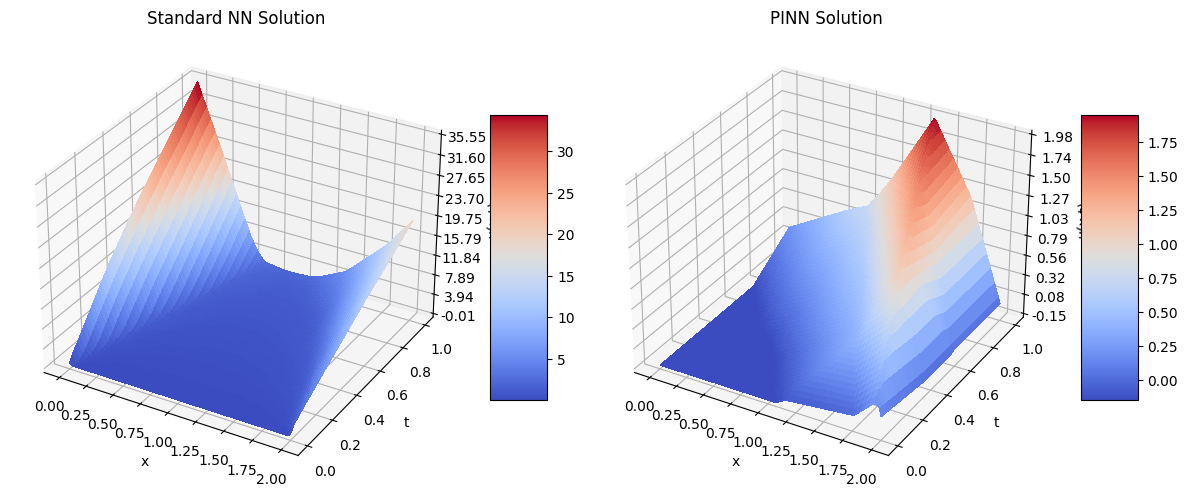

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the standard NN architecture (similar to PINN but without physics constraints)
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.hidden_layer = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1)  # Output layer (u(x,t))
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.hidden_layer(inputs)

# Instantiate the NN
nn_model = NN().to(device)

# Define the loss function and optimizer (same as before)
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3)

# Training loop (only supervised learning based on data points)
epochs = 10000

# Load data points from the MATLAB-generated solution (u_data.csv)
data = pd.read_csv("/content/u_data.csv")
data = data.rename(columns={'0': 'X', '0.1': 'U', '0.2': 'T'})

# Convert to torch tensors
data_x = torch.tensor(data['X'].values).float().reshape(-1, 1).to(device)
data_t = torch.tensor(data['T'].values).float().reshape(-1, 1).to(device)
data_u = torch.tensor(data['U'].values).float().reshape(-1, 1).to(device)

# Train the neural network based only on data
for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass through the NN
    u_pred = nn_model(data_x, data_t)

    # Compute the supervised data loss
    loss = criterion(u_pred, data_u)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

# Save the trained NN model
torch.save(nn_model.state_dict(), "nn_model_uxt.pt")

# Plotting the results after training for NN
fig = plt.figure(figsize=(12, 6))

# Generate grid for predictions
x = np.linspace(0, 2, 100)
t = np.linspace(0, 1, 100)
ms_x, ms_t = np.meshgrid(x, t)

# Prepare input for the network
x_flat = ms_x.ravel().reshape(-1, 1)
t_flat = ms_t.ravel().reshape(-1, 1)

pt_x = torch.tensor(x_flat).float().to(device)
pt_t = torch.tensor(t_flat).float().to(device)

# Get predictions from the trained model (NN)
pt_u_nn = nn_model(pt_x, pt_t)
u_nn = pt_u_nn.data.cpu().numpy()

# Reshape the predictions for plotting
ms_u_nn = u_nn.reshape(ms_x.shape)

# Plot the surface for NN predictions
ax = fig.add_subplot(121, projection='3d')
surf_nn = ax.plot_surface(ms_x, ms_t, ms_u_nn, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_title('Standard NN Solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf_nn, shrink=0.5, aspect=5)

# Load the previous PINN model and generate predictions for comparison
net = Net().to(device)
net.load_state_dict(torch.load("pinn_model_uxt_with_boundary.pt"))

# Get predictions from the trained model (PINN)
pt_u_pinn = net(pt_x, pt_t)
u_pinn = pt_u_pinn.data.cpu().numpy()

# Reshape the predictions for plotting
ms_u_pinn = u_pinn.reshape(ms_x.shape)

# Plot the surface for PINN predictions
ax = fig.add_subplot(122, projection='3d')
surf_pinn = ax.plot_surface(ms_x, ms_t, ms_u_pinn, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_title('PINN Solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf_pinn, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


Inferences:
NN vs. PINN:

Standard NN: The NN learns purely from the provided data points without any understanding of the underlying physics (PDE). This means that the NN may overfit or underfit depending on the amount of data.
PINN: The PINN incorporates the physics of the problem, ensuring that the learned solution adheres to the physical law (PDE). Therefore, even with less data, it can achieve more accurate results compared to a standard NN.
Expected Difference:

Accuracy: The PINN solution is expected to be closer to the analytical solution due to its knowledge of the PDE constraint. The NN's performance relies heavily on the amount and distribution of data.
Training: The NN may converge faster but could lack generalization if the data is sparse. The PINN may require more computational time but tends to generalize better across the domain.